1907
torch.Size([8, 4, 640, 960])
tensor([ 240.,  644.,  339.,  419.,  969.,  768.,  569.,  957.,  900.,  540.,
         440.,  488.,  532.,  851., 1039.])


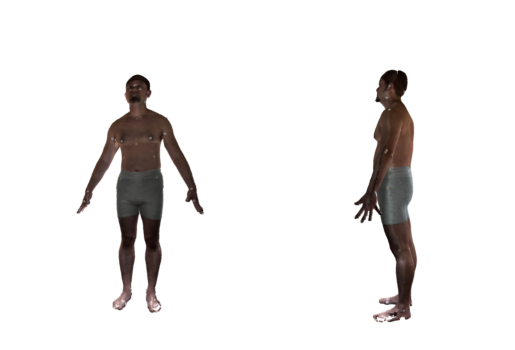

In [5]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms as T
import matplotlib.pyplot as plt

from dataload import BodyMeasurementDataset

torch.manual_seed(42)

train_dir = 'data/dataset/train'
val_dir = 'data/dataset/val'
test_dir = 'data/dataset/test'

# Paths to data directories and metadata files
train_images_dir = os.path.join(train_dir, 'images')
train_masks_dir = os.path.join(train_dir, 'masks')
train_metadata_file = os.path.join(train_dir, 'metadata.csv')

val_images_dir = os.path.join(val_dir, 'images')
val_masks_dir = os.path.join(val_dir, 'masks')
val_metadata_file = os.path.join(val_dir, 'metadata.csv')

test_images_dir = os.path.join(test_dir, 'images')
test_masks_dir = os.path.join(test_dir, 'masks')
test_metadata_file = os.path.join(test_dir, 'metadata.csv')

columns_list = [
    'Ankle Circumference (mm)',
    'Arm Length (Shoulder to Wrist) (mm)',
    'Arm Length (Shoulder to Elbow) (mm)', 
    'Armscye Circumference (Scye Circ Over Acromion) (mm)',
    'Chest Circumference (mm)',
    'Crotch Height (mm)',
    'Head Circumference (mm)',
    'Hip Circumference, Maximum (mm)',
    'Hip Circ Max Height (mm)',
    # 'Interscye Dst Stand (mm)',
    'Knee Height (mm)',
    'Neck Base Circumference (mm)',
    'Shoulder Breadth (mm)',
    'Thigh Circumference (mm)',
    'Waist Circumference, Pref (mm)',
    'Waist Height, Preferred (mm)'
]

# Define transformations
transform = T.Compose([
    T.Resize((640, 480)),
    T.ToTensor()
])

get_weight = False
get_gender = False

# Create datasets
train_dataset = BodyMeasurementDataset(train_dir, columns_list, transform, get_weight=get_weight, get_gender=get_gender)
val_dataset = BodyMeasurementDataset(val_dir, columns_list, transform, get_weight=get_weight, get_gender=get_gender)
test_dataset = BodyMeasurementDataset(test_dir, columns_list, transform, get_weight=get_weight, get_gender=get_gender)


print(len(train_dataset))
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)#, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)#, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)#, num_workers=4)

# Example usage
for inputs, targets in train_loader:
    print(inputs.shape)
    # print(measurements.shape)
    # print(measurements[0])
    print(targets[0])
    plt.imshow(inputs[0, :3, :, :].permute(1, 2, 0).numpy())
    plt.axis('off')  # Hide axes
    plt.show()
    break


In [2]:
import torch.optim as optim
import torch.nn as nn
torch.manual_seed(42)

from build_model import MeasureNet

# Instantiate the network and print its architecture
model = MeasureNet(num_outputs=len(columns_list), in_channels=inputs.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for param in model.parameters():
    param.requires_grad = False

for param in model.mlp.parameters():
    param.requires_grad = True

def check_for_nans(tensor, name):
    if torch.isnan(tensor).any():
        print(f"NaNs found in {name}")
        return True
    return False


In [3]:
torch.manual_seed(42)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    batch_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        if check_for_nans(inputs, "inputs") or check_for_nans(targets, "targets"):
            continue

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        epoch_loss += loss.item()
        batch_loss += loss.item()

        if (i+1)%1==0:
            print(f'Batch {i+1}/{len(train_loader)}, Loss: {batch_loss/1:.4f}')
            batch_loss = 0.0
    
    print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader):.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            if check_for_nans(inputs, "val inputs") or check_for_nans(targets, "val targets"):
                continue
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            if (i+1)%10==0:
                print(f'Batch {i+1}/{len(train_loader)}')
    
    print(f"Validation Loss: {val_loss / len(val_loader):.4f}")

Batch 1/239, Loss: 501467.1875
Batch 2/239, Loss: 516151.5625
Batch 3/239, Loss: 478460.9062
Batch 4/239, Loss: 457605.2188
Batch 5/239, Loss: 489676.5312
Batch 6/239, Loss: 432456.9375
Batch 7/239, Loss: 472054.1875
Batch 8/239, Loss: 454420.8438
Batch 9/239, Loss: 364042.0625
Batch 10/239, Loss: 359494.0312
Batch 11/239, Loss: 346655.5625
Batch 12/239, Loss: 271574.8750
Batch 13/239, Loss: 224341.4844
Batch 14/239, Loss: 239242.0469
Batch 15/239, Loss: 196934.4219
Batch 16/239, Loss: 193037.7500
Batch 17/239, Loss: 106145.1328
Batch 18/239, Loss: 108222.5469
NaNs found in targets
Batch 20/239, Loss: 96037.8516
Batch 21/239, Loss: 97633.8047
Batch 22/239, Loss: 60611.1523
Batch 23/239, Loss: 45852.2422
Batch 24/239, Loss: 50982.9102
Batch 25/239, Loss: 32477.9434
Batch 26/239, Loss: 37220.4805
Batch 27/239, Loss: 52481.2461
Batch 28/239, Loss: 34961.5352


KeyboardInterrupt: 